In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import *
from information_scores import *
from sklearn.linear_model import Lasso
import pandas as pd

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 16]

## Prepare Data

In [2]:
# Layout the lynx and hare data

time = np.arange(0,1905-1845,2) # original time 

hare = (np.array([20,20,52,83,64,68,83,12,3,150,110,
                  60,7,10,70,100,92,70,10,11,137,137,
                  18,22,52,83,18,10,9,65])) # original hare population values


lynx = (np.array([32,50,12,10,13,36,15,12,6,6,65,70,
                  40,9,20,34,45,40,15,15,60,80,26,18,
                  37,50,35,12,12,25])) # original lynx population values

time_new = np.linspace(0,1903-1845,500) # new time value
dt = np.abs(time_new[1]-time_new[2]) # the new time step

f_hare = interp1d(time,hare,'cubic') # hare inteprolation function

hare_interp = f_hare(time_new) # inteprolated hare population values

f_lynx = interp1d(time,lynx,'cubic') # lynx interpolation function

lynx_interp = f_lynx(time_new) # interpolated lynx population values

X = np.vstack([hare_interp,lynx_interp]) # data matrix

# create the X and Xprime matrices to pass to the SINDy function

# Fourth Order Central Difference
X1 = X[0,:]
X2 = X[1,:]

dX1 = (1/(12*dt)) * (-X1[4:] + 8*X1[3:-1] - 8*X1[1:-3] + X1[:-4])
X1 = X1[2:-2]

dX2 = (1/(12*dt)) * (-X2[4:] + 8*X2[3:-1] - 8*X2[1:-3] + X2[:-4])
X2 = X2[2:-2]

dX = np.vstack([dX1,dX2]) # data matrix

# Trim first and last two that are lost in derivative
X = X[:,2:-2].T
Xprime = dX.T


print(X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

(496, 2) (496, 2)


## Build Library of Functions for SINDY

In [3]:
def build_library(X):
    
    n = X.shape[0]
    Theta = np.zeros((n,1))
    function_label = []
    
    # first order polynomial in x (first state)
    first_state = X[:,0]
    Theta[:,0] = first_state
    function_label.append('x')
    
    # first order polynomial in y (second state)
    second_state = np.array([X[:,1]]).T
    Theta = np.append(Theta,second_state,axis=1)
    function_label.append('y')
    
    # first order polynomial in xy (product of states)
    product = np.array([X[:,0]*X[:,1]]).T
    Theta = np.append(Theta,product,axis = 1)
    function_label.append('xy')
    
    # second order polynomial in x
    x2 = np.array([X[:,0]*X[:,0]]).T
    Theta = np.append(Theta,x2,axis = 1)
    function_label.append('x^2')
    
    # second order polynomial in y
    y2 = np.array([X[:,1]*X[:,1]]).T
    Theta = np.append(Theta,y2,axis = 1)
    function_label.append('y^2')
    
    # second order polynomial in xy
    xy2 = np.array([(X[:,0]*X[:,1])**2]).T
    Theta = np.append(Theta,xy2,axis = 1)
    function_label.append('(xy)^2')
    
    period1 = 5 
    # sin(omega*x), omega = (2*pi)/T , T = 5 years
    sinx = np.array([np.sin(2*np.pi*X[:,0]/period1)]).T
    Theta = np.append(Theta,sinx,axis = 1)
    function_label.append('sin(omega1*x)')
    
    # sin(omega*y), omega = (2*pi)/T , T = 5 years
    siny = np.array([np.sin(2*np.pi*X[:,1]/period1)]).T
    Theta = np.append(Theta,siny,axis = 1)
    function_label.append('sin(omega1*y)')
    
    # sin(omega*xy), omega = (2*pi)/T , T = 5 years
    sinxy = np.array([np.sin(2*np.pi*(X[:,1]*X[:,0])/period1)]).T
    Theta = np.append(Theta,sinxy,axis = 1)
    function_label.append('sin(omega1*xy)')
    
    period2 = 15
    # sin(omega*x), omega = (2*pi)/T , T = 15 years
    sinx2 = np.array([np.sin(2*np.pi*X[:,0]/period2)]).T
    Theta = np.append(Theta,sinx2,axis = 1)
    function_label.append('sin(omega2*x)')
    
    # sin(omega*y), omega = (2*pi)/T , T = 15 years
    siny2 = np.array([np.sin(2*np.pi*X[:,1]/period2)]).T
    Theta = np.append(Theta,siny2,axis = 1)
    function_label.append('sin(omega2*y)')
    
    # sin(omega*xy), omega = (2*pi)/T , T = 15 years
    sinxy2 = np.array([np.sin(2*np.pi*(X[:,1]*X[:,0])/period2)]).T
    Theta = np.append(Theta,sinxy2,axis = 1)
    function_label.append('sin(omega2*xy)')
    
    return Theta, function_label


def Sparse_Regression(Theta,dXdt,thresh):
    
    lassoreg = Lasso(alpha=thresh,normalize=True, max_iter=1e5) # sparsify!!!!! Hell yeah!!!
    lassoreg.fit(Theta,dXdt)
    Xi = lassoreg.coef_
    
    return Xi.T

## Obtain Co-efficients

In [37]:
Theta,function_label = build_library(X) # build the lbrary of functions (Theta)
threshold = 0.001 # thresholding paramater for sparsification
Xi = Sparse_Regression(Theta,Xprime,threshold) # obtain Xi ("ksi") that gives us the coefficients
Xi = np.asarray(Xi)
print(Xi1) # print out Xi as a sanity check

[[ 1.105530e-01  0.000000e+00]
 [-7.132510e-01 -0.000000e+00]
 [-4.610000e-04  5.190000e-04]
 [ 0.000000e+00  1.162000e-03]
 [ 0.000000e+00 -2.300000e-03]
 [ 0.000000e+00 -0.000000e+00]
 [ 1.620748e+00  2.213700e-01]
 [-1.815202e+00  6.918500e-02]
 [-7.468080e-01  1.848730e-01]
 [ 2.559030e-01  7.192700e-01]
 [ 7.482325e+00 -5.408260e-01]
 [ 1.323320e-01 -0.000000e+00]]


In [38]:
states = ['x','y']
df = pd.DataFrame(Xi,index = function_label, columns = states)
A=df.head(12)
A

,x,y
x,2.613782e-01,-1.190073e-01
y,-6.923566e-01,-7.572605e-02
xy,-5.020830e-03,4.651794e-03
x^2,-5.622399e-04,1.630049e-03
y^2,1.912258e-03,-3.461607e-03
(xy)^2,3.329057e-07,-2.704507e-07
sin(omega1*x),1.742687e+00,6.190794e-01
sin(omega1*y),-2.042317e+00,3.458981e-01
sin(omega1*xy),-1.014536e+00,4.195040e-01
sin(omega2*x),3.334849e-01,1.164758e+00


# Use Implicit Solver

In [39]:
def Lotka_Volterra1(t,X,Xi):
    
    x = X[0]
    y = X[1]
    
    omega1 = 2*np.pi/5
    omega2 = 2*np.pi/15
    
    library = (np.array([x, y, x*y, x**2, y**2, (x*y)**2, np.sin(omega1*x), np.sin(omega1*y), np.sin(omega1*x*y),
                     np.sin(omega2*x), np.sin(omega2*y), np.sin(omega2*x*y)]))

    dXdt = np.dot(Xi.T,library)
    
    xdot = dXdt[0]
    ydot = dXdt[1]
    
    return [xdot, ydot]

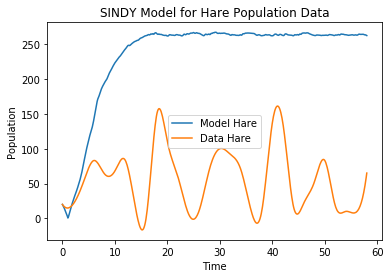

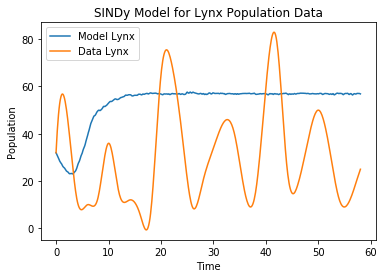

In [40]:
P0 = [20, 32]
tspan = np.asarray([time_new[0],time_new[-1]])

Ps = solve_ivp(Lotka_Volterra1, tspan, P0, method = 'RK45', args=(Xi,),t_eval = time_new)
hare_pop = np.abs(Ps.y[0,:])
lynx_pop = np.abs(Ps.y[1,:])

plt.plot(time_new, hare_pop, label="Model Hare")
plt.plot(time_new, hare_interp, label="Data Hare")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SINDY Model for Hare Population Data")
plt.legend()
plt.show()

plt.plot(time_new, lynx_pop, label="Model Lynx")
plt.plot(time_new, lynx_interp, label="Data Lynx")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SINDy Model for Lynx Population Data")
plt.legend()
plt.show()